In [ ]:
import torch
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# NLP Initiation



## Starting with a emotion classification problem

- get a dataset

In [ ]:
url_train = '/content/train.txt'
url_test = '/content/test.txt'

separator = ';'

train_data = pd.read_table(url_train, sep=separator, header=None)
train_data.columns = ['Text', 'Labels']
display(train_data)

Text   Labels
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
15995  i just had a very brief time in the beanbag an...  sadness
15996  i am now turning and i feel pathetic that i am...  sadness
15997                     i feel strong and good overall      joy
15998  i feel like this was such a rude comment and i...    anger
15999  i know a lot but i feel so stupid because i ca...  sadness

[16000 rows x 2 columns]

In [ ]:
test_data = pd.read_table(url_test, sep=separator, header=None)
test_data.columns = ['Text', 'Labels']
display(test_data)

Text   Labels
0     im feeling rather rotten so im not very ambiti...  sadness
1             im updating my blog because i feel shitty  sadness
2     i never make her separate from me because i do...  sadness
3     i left with my bouquet of red and yellow tulip...      joy
4       i was feeling a little vain when i did this one  sadness
...                                                 ...      ...
1995  i just keep feeling like someone is being unki...    anger
1996  im feeling a little cranky negative after this...    anger
1997  i feel that i am useful to my people and that ...      joy
1998  im feeling more comfortable with derby i feel ...      joy
1999  i feel all weird when i have to meet w people ...     fear

[2000 rows x 2 columns]

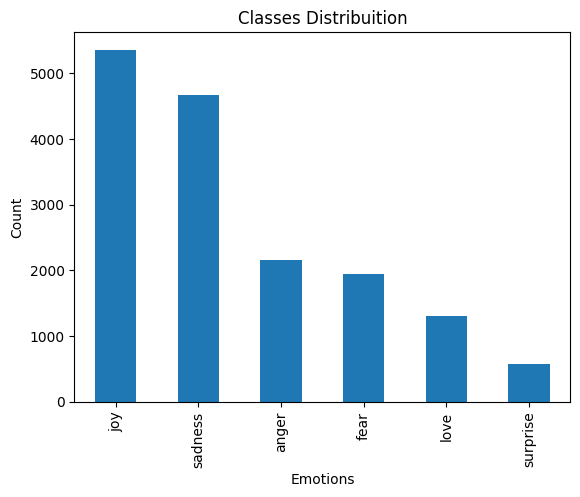

In [ ]:
# Visualize train
counts = train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

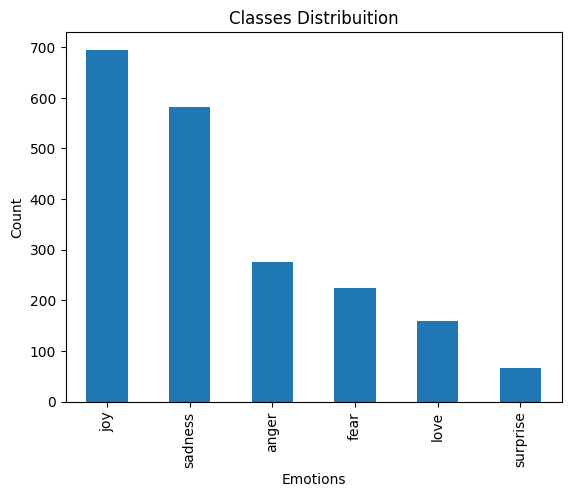

In [ ]:
# visualize test
counts = test_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

## As we can see, the data is unbalanced. Let's do data augmentation



In [ ]:
import pandas as pd
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import nltk
import random
nltk.download('punkt')


def generate_synonyms_paraphrases(text, emotion, target_emotion, num_aug):
    """
    Gera sinônimos e paráfrases para uma frase, priorizando a emoção alvo.

    Args:
      text (str): Frase original.
      emotion (str): Emoção original da frase.
      target_emotion (str): Emoção alvo para o data augmentation.

    Returns:
      list: Lista de frases com sinônimos e paráfrases.
    """
    synonyms_paraphrases = set()
    num_augmentations = num_aug
    if emotion == target_emotion:
        for _ in range(num_augmentations):
            new_text = text
            for token in word_tokenize(text):
                synsets = wn.synsets(token)
                synonyms = []
                for synset in synsets:
                    synonyms.extend(synset.lemma_names())
                synonyms = list(set(synonyms))

                selected_synonyms = [syn for syn in synonyms if wn.synsets(syn) and wn.synsets(syn)[0].name().split('.')[0] == emotion]
                if selected_synonyms:
                    synonym_to_replace = random.choice(selected_synonyms)
                    new_text = new_text.replace(token, synonym_to_replace, 1)
            synonyms_paraphrases.add((new_text, emotion))
    return list(synonyms_paraphrases)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RFFSo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RFFSo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(train_data['Text'], train_data['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="surprise", num_aug=5000)
  train_augmented.extend(synonyms_paraphrases)

16989it [3:24:11,  1.39it/s]


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented.csv


In [ ]:
name_train = 'train_en.txt'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text    Labels
0    Curiosity fills me as i contemplate exploring ...  surprise
1    ive been taking or milligrams or times recomme...  surprise
2    i feel shocked that you d stoup to destinys ch...  surprise
3    I'm genuinely taken aback that you would stoop...  surprise
4    I'm genuinely taken aback that you would stoop...  surprise
..                                                 ...       ...
710  i spent a lot of time feeling a bit stunned th...  surprise
711  i believe the most readers feel impressed by t...  surprise
712      i have to admit im feeling pretty overwhelmed  surprise
713  i am feeling much like the guy in the pic abov...  surprise
714  i need to do this that and the other for colle...  surprise

[715 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

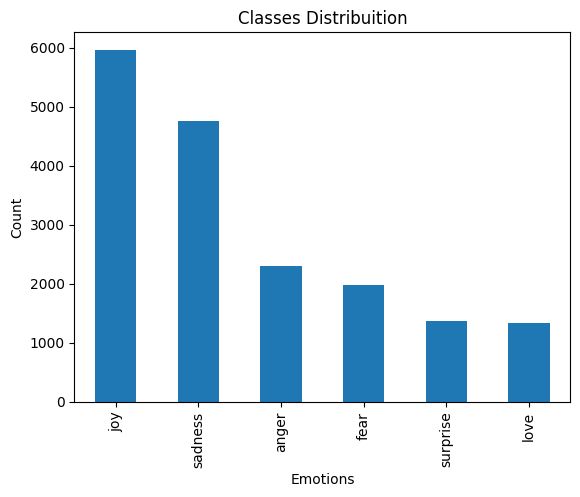

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
number_of_surprise_labels = aug_train_data['Labels'].value_counts()['surprise']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 1367


In [ ]:
train_augmented_2 = []
for text, emotion in tqdm(zip(train_augmented['Text'], train_augmented['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="surprise", num_aug=500)
  train_augmented_2.extend(synonyms_paraphrases)

715it [22:41,  1.90s/it]


In [ ]:
import os

train_augmented_df_2 = pd.DataFrame(train_augmented_2, columns=['Text', 'Labels'])
train_augmented_df_2.to_csv('train_augmented_2.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_2.csv')

train_augmented_df_2.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_2.csv


In [ ]:
name_train = 'train_en.txt'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_2.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented_2 = pd.read_csv(url_aug, sep=separator)
train_augmented_2.drop(train_augmented_2.columns[0], axis=1, inplace=True)
display(train_augmented_2)

Text    Labels
0    Curiosity fills me as i contemplate exploring ...  surprise
1    ive been taking or milligrams or times recomme...  surprise
2    i feel shocked that you d stoup to destinys ch...  surprise
3    I'm genuinely taken aback that you would stoop...  surprise
4    I'm genuinely taken aback that you would stoop...  surprise
..                                                 ...       ...
836  i spent a lot of time feeling a bit stunned th...  surprise
837  i believe the most readers feel impressed by t...  surprise
838      i have to admit im feeling pretty overwhelmed  surprise
839  i am feeling much like the guy in the pic abov...  surprise
840  i need to do this that and the other for colle...  surprise

[841 rows x 2 columns]

In [ ]:
aug_train_data_2 = pd.concat([train_data, train_augmented, train_augmented_2], ignore_index=True)

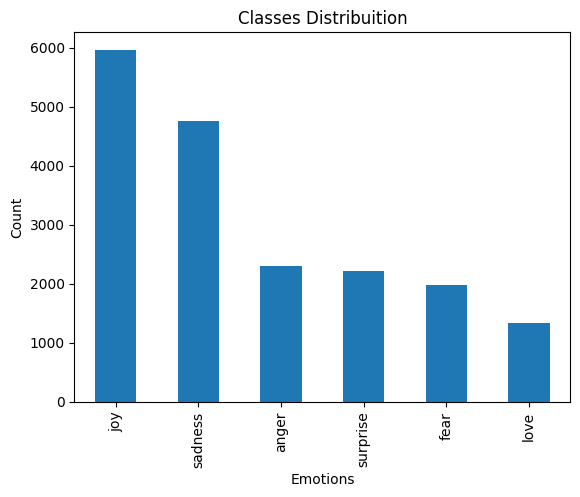

In [ ]:
# Visualize train
counts = aug_train_data_2['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
number_of_surprise_labels = aug_train_data_2['Labels'].value_counts()['surprise']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 2208


In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(aug_train_data_2['Text'], aug_train_data_2['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="surprise", num_aug=4)
  train_augmented.extend(synonyms_paraphrases)

18545it [00:37, 494.95it/s] 


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented_3.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_3.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_3.csv


In [ ]:
name_train = 'train_en.txt'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_3.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text    Labels
0     Curiosity fills me as i contemplate exploring ...  surprise
1     ive been taking or milligrams or times recomme...  surprise
2     i feel shocked that you d stoup to destinys ch...  surprise
3     I'm genuinely taken aback that you would stoop...  surprise
4                   snuffling dog searching for a scent  surprise
...                                                 ...       ...
2590  i spent a lot of time feeling a bit stunned th...  surprise
2591  i believe the most readers feel impressed by t...  surprise
2592      i have to admit im feeling pretty overwhelmed  surprise
2593  i am feeling much like the guy in the pic abov...  surprise
2594  i need to do this that and the other for colle...  surprise

[2595 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

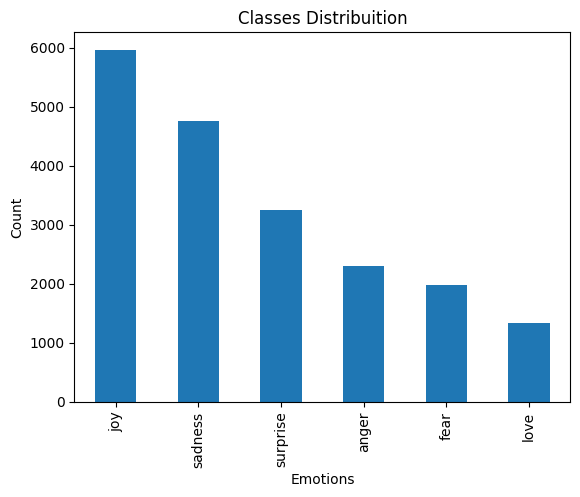

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
number_of_surprise_labels = aug_train_data['Labels'].value_counts()['surprise']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 3247


In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(aug_train_data['Text'], aug_train_data['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="surprise", num_aug=4)
  train_augmented.extend(synonyms_paraphrases)

19584it [00:51, 381.00it/s] 


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented_4.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_4.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_4.csv


In [ ]:
name_train = 'train_en.txt'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_4.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text    Labels
0     Curiosity fills me as i contemplate exploring ...  surprise
1     ive been taking or milligrams or times recomme...  surprise
2     i feel shocked that you d stoup to destinys ch...  surprise
3     I'm genuinely taken aback that you would stoop...  surprise
4     I'm genuinely taken aback that you would stoop...  surprise
...                                                 ...       ...
3998  i spent a lot of time feeling a bit stunned th...  surprise
3999  i believe the most readers feel impressed by t...  surprise
4000      i have to admit im feeling pretty overwhelmed  surprise
4001  i am feeling much like the guy in the pic abov...  surprise
4002  i need to do this that and the other for colle...  surprise

[4003 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

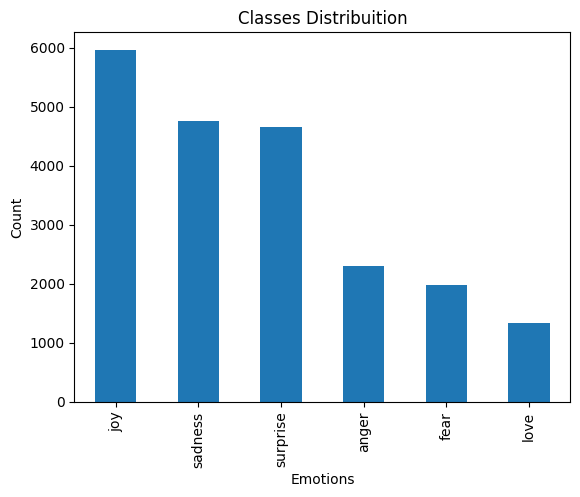

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
import os

aug_train_data.to_csv('aug_train_data.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'aug_train_data.csv')

aug_train_data.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\aug_train_data.csv


In [ ]:
number_of_surprise_labels = aug_train_data['Labels'].value_counts()['anger']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 2303


In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(aug_train_data['Text'], aug_train_data['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="anger", num_aug=4)
  train_augmented.extend(synonyms_paraphrases)

20992it [00:39, 534.50it/s]


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented_5.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_5.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_5.csv


In [ ]:
name_train = 'aug_train_data.csv'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_5.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text Labels
0     discovering the plot twist in the storyline fi...  anger
1     discovering the plot twist in the storyline fi...  anger
2     discovering the plot twist in the storyline fi...  anger
3     expressing my genuine dislike for quinn arises...  anger
4     expressing my genuine dislike for quinn arises...  anger
...                                                 ...    ...
2361          i have a feeling im going to be heartless  anger
2362  i often find my self feeling offended myself w...  anger
2363  i took a minute to appreciate the trees around...  anger
2364  i moved away he said something that made me fe...  anger
2365  i feel like this was such a rude comment and i...  anger

[2366 rows x 2 columns]

In [ ]:
separator = ','
train_data = pd.read_csv(url_train, sep=separator)
train_data.drop(train_data.columns[0], axis=1, inplace=True)
display(train_data)

Text    Labels
0                    thebelofiloufeufo i feel humiliated   sadness
1      discovering the plot twist in the storyline fi...     anger
2      expressing my genuine dislike for quinn arises...     anger
3      i can go from feeling so hopeless to so damned...   sadness
4      i deeply yearn to discover my niche here in ve...   sadness
...                                                  ...       ...
20987  i spent a lot of time feeling a bit stunned th...  surprise
20988  i believe the most readers feel impressed by t...  surprise
20989      i have to admit im feeling pretty overwhelmed  surprise
20990  i am feeling much like the guy in the pic abov...  surprise
20991  i need to do this that and the other for colle...  surprise

[20992 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

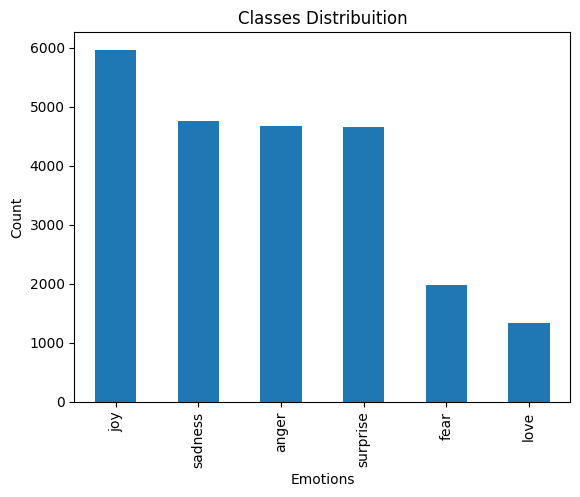

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
import os

aug_train_data.to_csv('aug_train_data.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'aug_train_data.csv')

aug_train_data.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\aug_train_data.csv


In [ ]:
number_of_surprise_labels = aug_train_data['Labels'].value_counts()['fear']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 1983


In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(aug_train_data['Text'], aug_train_data['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="fear", num_aug=4)
  train_augmented.extend(synonyms_paraphrases)

23358it [00:34, 685.00it/s]


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented_6.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_6.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_6.csv


In [ ]:
name_train = 'aug_train_data.csv'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_6.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text Labels
0     i sense their apprehension towards fats, a fee...   fear
1     i sense their apprehension towards fats, a fee...   fear
2     i sense their apprehension towards fats, a fee...   fear
3     i feel as confused about life as a teenager or...   fear
4     Anxiety started to creep in as May draws to a ...   fear
...                                                 ...    ...
2023  i can understand feeling uncertain about the a...   fear
2024  i inspect samples of wheat i started feeling t...   fear
2025  i remember waking up feeling anxious and excit...   fear
2026  i have writer s block or feel too apprehensive...   fear
2027  im still feeling all wimpy it may be another s...   fear

[2028 rows x 2 columns]

In [ ]:
separator = ','
train_data = pd.read_csv(url_train, sep=separator)
train_data.drop(train_data.columns[0], axis=1, inplace=True)
display(train_data)

Text   Labels
0                    thebelofiloufeufo i feel humiliated  sadness
1      discovering the plot twist in the storyline fi...    anger
2      expressing my genuine dislike for quinn arises...    anger
3      i can go from feeling so hopeless to so damned...  sadness
4      i deeply yearn to discover my niche here in ve...  sadness
...                                                  ...      ...
23353          i have a feeling im going to be heartless    anger
23354  i often find my self feeling offended myself w...    anger
23355  i took a minute to appreciate the trees around...    anger
23356  i moved away he said something that made me fe...    anger
23357  i feel like this was such a rude comment and i...    anger

[23358 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

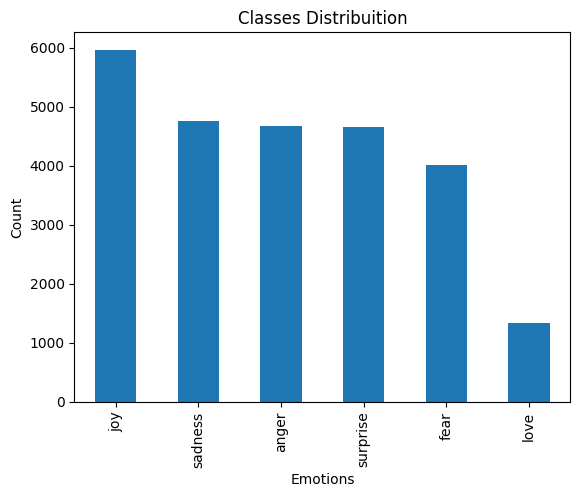

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
import os

aug_train_data.to_csv('aug_train_data.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'aug_train_data.csv')

aug_train_data.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\aug_train_data.csv


In [ ]:
number_of_surprise_labels = aug_train_data['Labels'].value_counts()['love']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 1336


In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(aug_train_data['Text'], aug_train_data['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="love", num_aug=4)
  train_augmented.extend(synonyms_paraphrases)

25386it [00:24, 1040.65it/s]


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented_7.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_7.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_7.csv


In [ ]:
name_train = 'aug_train_data.csv'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_7.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text Labels
0     i am ever feeling nostalgic about the fireplac...   love
1                                   i feel romantic too   love
2     i feel a pain in my own heart as every prieste...   love
3     i experience a twinge in my own heart as each ...   love
4     i experience a twinge in my own heart as each ...   love
...                                                 ...    ...
1579  i love what i do and i feel so blessed and luc...   love
1580  i erotic_love what i do and i feel so blessed ...   love
1581  i feel it would not be love of me not warn you...   love
1582  i feel it would not be loving of me not warn y...   love
1583      i feel so sympathetic empathetic towards them   love

[1584 rows x 2 columns]

In [ ]:
separator = ','
train_data = pd.read_csv(url_train, sep=separator)
train_data.drop(train_data.columns[0], axis=1, inplace=True)
display(train_data)

Text   Labels
0                    thebelofiloufeufo i feel humiliated  sadness
1      discovering the plot twist in the storyline fi...    anger
2      expressing my genuine dislike for quinn arises...    anger
3      i can go from feeling so hopeless to so damned...  sadness
4      i deeply yearn to discover my niche here in ve...  sadness
...                                                  ...      ...
25381  i can understand feeling uncertain about the a...     fear
25382  i inspect samples of wheat i started feeling t...     fear
25383  i remember waking up feeling anxious and excit...     fear
25384  i have writer s block or feel too apprehensive...     fear
25385  im still feeling all wimpy it may be another s...     fear

[25386 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

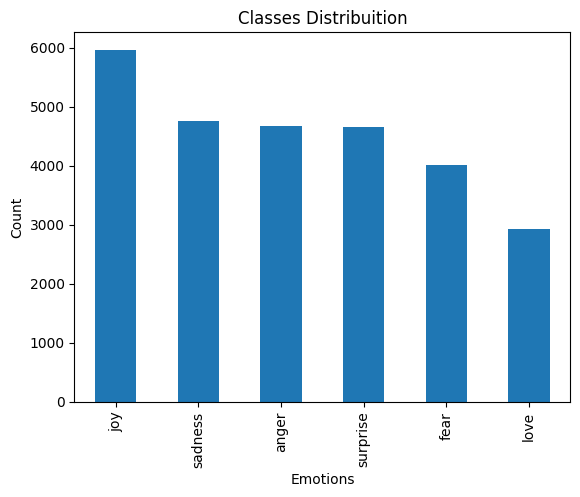

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
import os

aug_train_data.to_csv('aug_train_data.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'aug_train_data.csv')

aug_train_data.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\aug_train_data.csv


In [ ]:
number_of_surprise_labels = aug_train_data['Labels'].value_counts()['love']

print(f"Número de labels de 'surpresa': {number_of_surprise_labels}")

Número de labels de 'surpresa': 2920


In [ ]:
train_augmented = []
for text, emotion in tqdm(zip(aug_train_data['Text'], aug_train_data['Labels'])):
  synonyms_paraphrases = generate_synonyms_paraphrases(text, emotion, target_emotion="love", num_aug=4)
  train_augmented.extend(synonyms_paraphrases)

26970it [00:52, 511.70it/s]  


In [ ]:
import os

train_augmented_df = pd.DataFrame(train_augmented, columns=['Text', 'Labels'])
train_augmented_df.to_csv('train_augmented_7.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'train_augmented_8.csv')

train_augmented_df.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\train_augmented_8.csv


In [ ]:
name_train = 'aug_train_data.csv'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_8.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_augmented = pd.read_csv(url_aug, sep=separator)
train_augmented.drop(train_augmented.columns[0], axis=1, inplace=True)
display(train_augmented)

Text Labels
0     i am ever feeling nostalgic about the fireplac...   love
1                                   i feel romantic too   love
2     i feel a pain in my own heart as every prieste...   love
3     i experience a twinge in my own heart as each ...   love
4     i experience a twinge in my own heart as each ...   love
...                                                 ...    ...
4046  i feel it would not be erotic_love of me not w...   love
4047  i feel it would not be love of me not warn you...   love
4048  i feel it would not be love of me not warn you...   love
4049  i feel it would not be loving of me not warn y...   love
4050      i feel so sympathetic empathetic towards them   love

[4051 rows x 2 columns]

In [ ]:
separator = ','
train_data = pd.read_csv(url_train, sep=separator)
train_data.drop(train_data.columns[0], axis=1, inplace=True)
display(train_data)

Text   Labels
0                    thebelofiloufeufo i feel humiliated  sadness
1      discovering the plot twist in the storyline fi...    anger
2      expressing my genuine dislike for quinn arises...    anger
3      i can go from feeling so hopeless to so damned...  sadness
4      i deeply yearn to discover my niche here in ve...  sadness
...                                                  ...      ...
25381  i can understand feeling uncertain about the a...     fear
25382  i inspect samples of wheat i started feeling t...     fear
25383  i remember waking up feeling anxious and excit...     fear
25384  i have writer s block or feel too apprehensive...     fear
25385  im still feeling all wimpy it may be another s...     fear

[25386 rows x 2 columns]

In [ ]:
aug_train_data = pd.concat([train_data, train_augmented], ignore_index=True)

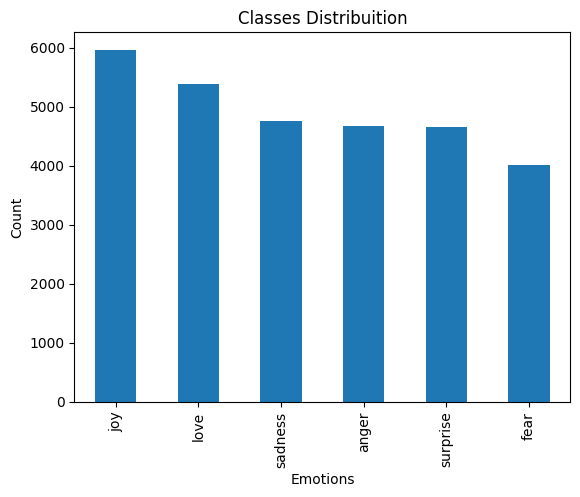

In [ ]:
# Visualize train
counts = aug_train_data['Labels'].value_counts()
counts.plot(kind='bar')
plt.title('Classes Distribuition')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
import os

aug_train_data.to_csv('aug_train_data.csv')

path_downloads = os.path.join(os.path.expanduser('~'), 'Downloads', 'aug_train_data.csv')

aug_train_data.to_csv(path_downloads)

print(f"Arquivo salvo em: {path_downloads}")

Arquivo salvo em: C:\Users\RFFSo\Downloads\aug_train_data.csv


## data balanced with success

In [ ]:
name_train = 'aug_train_data.csv'
name_test = 'test.txt'
name_val = 'val_en.txt'
aug_name = 'train_augmented_8.csv'

url_aug = path_downloads / aug_name
url_train = path_downloads / name_train
url_test = path_downloads / name_test
url_val = path_downloads / name_val

In [ ]:
separator = ','
train_data = pd.read_csv(url_train, sep=separator)
train_data.drop(train_data.columns[0], axis=1, inplace=True)
display(train_data)

Text   Labels
0                    thebelofiloufeufo i feel humiliated  sadness
1      discovering the plot twist in the storyline fi...    anger
2      expressing my genuine dislike for quinn arises...    anger
3      i can go from feeling so hopeless to so damned...  sadness
4      i deeply yearn to discover my niche here in ve...  sadness
...                                                  ...      ...
29432  i feel it would not be erotic_love of me not w...     love
29433  i feel it would not be love of me not warn you...     love
29434  i feel it would not be love of me not warn you...     love
29435  i feel it would not be loving of me not warn y...     love
29436      i feel so sympathetic empathetic towards them     love

[29437 rows x 2 columns]

In [ ]:
separator = ";"
test_data = pd.read_table(url_test, sep=separator, header=None)
test_data.columns = ['Text', 'Labels']
display(test_data)

Text   Labels
0     im feeling rather rotten so im not very ambiti...  sadness
1             im updating my blog because i feel shitty  sadness
2     i never make her separate from me because i do...  sadness
3     i left with my bouquet of red and yellow tulip...      joy
4       i was feeling a little vain when i did this one  sadness
...                                                 ...      ...
1995  i just keep feeling like someone is being unki...    anger
1996  im feeling a little cranky negative after this...    anger
1997  i feel that i am useful to my people and that ...      joy
1998  im feeling more comfortable with derby i feel ...      joy
1999  i feel all weird when i have to meet w people ...     fear

[2000 rows x 2 columns]

In [ ]:
val_data = pd.read_table(url_val, sep=separator, header=None)
val_data.columns = ['Text', 'Labels']
display(val_data)

Text   Labels
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv...  sadness
2                        i feel like a faithful servant     love
3                     i am just feeling cranky and blue    anger
4     i can have for a treat or if i am feeling festive      joy
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

[2000 rows x 2 columns]

# data preprocessing

In [ ]:
emotion_to_index = {emotion: index for index, emotion in enumerate(train_data['Labels'].unique())}
display(emotion_to_index)

{'sadness': 0, 'anger': 1, 'surprise': 2, 'love': 3, 'fear': 4, 'joy': 5}

In [ ]:
train_data['Labels'] = train_data['Labels'].map(emotion_to_index)
test_data['Labels'] = test_data['Labels'].map(emotion_to_index)
val_data['Labels'] = val_data['Labels'].map(emotion_to_index)
display(train_data, test_data, val_data)

Text  Labels
0                    thebelofiloufeufo i feel humiliated       0
1      discovering the plot twist in the storyline fi...       1
2      expressing my genuine dislike for quinn arises...       1
3      i can go from feeling so hopeless to so damned...       0
4      i deeply yearn to discover my niche here in ve...       0
...                                                  ...     ...
29432  i feel it would not be erotic_love of me not w...       3
29433  i feel it would not be love of me not warn you...       3
29434  i feel it would not be love of me not warn you...       3
29435  i feel it would not be loving of me not warn y...       3
29436      i feel so sympathetic empathetic towards them       3

[29437 rows x 2 columns]

Text  Labels
0     im feeling rather rotten so im not very ambiti...       0
1             im updating my blog because i feel shitty       0
2     i never make her separate from me because i do...       0
3     i left with my bouquet of red and yellow tulip...       5
4       i was feeling a little vain when i did this one       0
...                                                 ...     ...
1995  i just keep feeling like someone is being unki...       1
1996  im feeling a little cranky negative after this...       1
1997  i feel that i am useful to my people and that ...       5
1998  im feeling more comfortable with derby i feel ...       5
1999  i feel all weird when i have to meet w people ...       4

[2000 rows x 2 columns]

Text  Labels
0     im feeling quite sad and sorry for myself but ...       0
1     i feel like i am still looking at a blank canv...       0
2                        i feel like a faithful servant       3
3                     i am just feeling cranky and blue       1
4     i can have for a treat or if i am feeling festive       5
...                                                 ...     ...
1995  im having ssa examination tomorrow in the morn...       0
1996  i constantly worry about their fight against n...       5
1997  i feel its important to share this info for th...       5
1998  i truly feel that if you are passionate enough...       5
1999  i feel like i just wanna buy any cute make up ...       5

[2000 rows x 2 columns]

In [ ]:
import torchtext
from torchtext.transforms import RegexTokenizer

patterns_list = [(r',', ' '), (r'"', '')]
tokenizer = RegexTokenizer(patterns_list)

train_data['Text'] = train_data['Text'].apply(lambda x: tokenizer(x))
test_data['Text'] = test_data['Text'].apply(lambda x: tokenizer(x))
val_data['Text'] = val_data['Text'].apply(lambda x: tokenizer(x))
display(train_data, test_data, val_data)

Text  Labels
0               [thebelofiloufeufo, i, feel, humiliated]       0
1      [discovering, the, plot, twist, in, the, story...       1
2      [expressing, my, genuine, dislike, for, quinn,...       1
3      [i, can, go, from, feeling, so, hopeless, to, ...       0
4      [i, deeply, yearn, to, discover, my, niche, he...       0
...                                                  ...     ...
29432  [i, feel, it, would, not, be, erotic_love, of,...       3
29433  [i, feel, it, would, not, be, love, of, me, no...       3
29434  [i, feel, it, would, not, be, love, of, me, no...       3
29435  [i, feel, it, would, not, be, loving, of, me, ...       3
29436  [i, feel, so, sympathetic, empathetic, towards...       3

[29437 rows x 2 columns]

Text  Labels
0     [im, feeling, rather, rotten, so, im, not, ver...       0
1     [im, updating, my, blog, because, i, feel, shi...       0
2     [i, never, make, her, separate, from, me, beca...       0
3     [i, left, with, my, bouquet, of, red, and, yel...       5
4     [i, was, feeling, a, little, vain, when, i, di...       0
...                                                 ...     ...
1995  [i, just, keep, feeling, like, someone, is, be...       1
1996  [im, feeling, a, little, cranky, negative, aft...       1
1997  [i, feel, that, i, am, useful, to, my, people,...       5
1998  [im, feeling, more, comfortable, with, derby, ...       5
1999  [i, feel, all, weird, when, i, have, to, meet,...       4

[2000 rows x 2 columns]

Text  Labels
0     [im, feeling, quite, sad, and, sorry, for, mys...       0
1     [i, feel, like, i, am, still, looking, at, a, ...       0
2                 [i, feel, like, a, faithful, servant]       3
3             [i, am, just, feeling, cranky, and, blue]       1
4     [i, can, have, for, a, treat, or, if, i, am, f...       5
...                                                 ...     ...
1995  [im, having, ssa, examination, tomorrow, in, t...       0
1996  [i, constantly, worry, about, their, fight, ag...       5
1997  [i, feel, its, important, to, share, this, inf...       5
1998  [i, truly, feel, that, if, you, are, passionat...       5
1999  [i, feel, like, i, just, wanna, buy, any, cute...       5

[2000 rows x 2 columns]

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from itertools import chain

# Create vocab
word_to_idx = build_vocab_from_iterator(map(lambda x: x[1]['Text'], chain(train_data.iterrows(), test_data.iterrows(), val_data.iterrows())))
display(len(word_to_idx))

17581

In [ ]:
train_data['Text'] = [[word_to_idx[word] if word in word_to_idx else default_index for word in text] for text in train_data['Text']]

In [ ]:
default_index = len(word_to_idx)
test_data['Text'] = [[word_to_idx[word] if word in word_to_idx else default_index for word in text] for text in test_data['Text']]

In [ ]:
val_data['Text'] = [[word_to_idx[word] if word in word_to_idx else default_index for word in text] for text in val_data['Text']]

In [ ]:
# Preprocess text
X_train = train_data['Text'].values
y_train = train_data['Labels'].values

X_val = val_data['Text'].values
y_val = val_data['Labels'].values

X_test = test_data['Text'].values
y_test = test_data['Labels'].values

In [ ]:
input_data = X_train
labels = y_train
input_data_val = X_val
labels_val = y_val
input_test = X_test
labels_test = y_test

# Converting to PyTorch Tensors
X_train = [torch.LongTensor(seq) for seq in input_data]
y_train = torch.LongTensor(labels)
X_val = [torch.LongTensor(seq) for seq in input_data_val]
y_val = torch.LongTensor(labels_val)
X_test = [torch.LongTensor(seq) for seq in input_test]
y_test = torch.LongTensor(labels_test)

# device agnostic code
X_train = [seq.to(device) for seq in X_train]
y_train = y_train.to(device)
X_val = [seq.to(device) for seq in X_val]
y_val = y_val.to(device)
X_test = [seq.to(device) for seq in X_test]
y_test = y_test.to(device)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

X_train_padded = pad_sequence(X_train, batch_first=True)
X_test_padded = pad_sequence(X_test, batch_first=True)
X_val_padded = pad_sequence(X_val, batch_first=True)

# maintain device agnostic code
X_train = X_train_padded.to(device)
X_test = X_test_padded.to(device)
X_val = X_val_padded.to(device)

In [ ]:
X_train.shape

torch.Size([29437, 66])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleEmbedding(nn.Module):
    def __init__(self, vocab_size, max_len, d_model, num_classes):
        super(SimpleEmbedding, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, d_model, mode='mean')
        self.linear1 = nn.Linear(d_model, d_model * 3)
        self.final_linear = nn.Linear(d_model * 3, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.final_linear(x)
        return x

vocab_size = len(word_to_idx)
max_len = 66
d_model = 1554
num_classes = 6

model_28 = SimpleEmbedding(vocab_size, max_len, d_model, num_classes)
model_28.to(device)
model_28

SimpleEmbedding(
  (embedding): EmbeddingBag(17581, 1554, mode='mean')
  (linear1): Linear(in_features=1554, out_features=4662, bias=True)
  (final_linear): Linear(in_features=4662, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
total_params = sum(p.numel() for p in model_28.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_28.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

34,598,262 total parameters.
34,598,262 training parameters.



In [ ]:
def loading(model_path, device, word_idx, model, class_name, optim):
    checkpoint = torch.load(model_path, map_location=torch.device(device))

    vocab_size = len(word_to_idx)
    max_len = 66
    d_model = 1554
    num_classes = 6

    model = class_name(vocab_size, max_len, d_model, num_classes)


    model.load_state_dict(checkpoint['model_state_dict'])

    optim = torch.optim.SGD(params=model.parameters(),
                            lr=0.001)

    optim.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else 0
    loss = checkpoint['loss'] if 'loss' in checkpoint else None

    model.to(device)
    return model

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 2440

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_no_tgt(epochs, model):

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_acc = 0

        for batch in train_loader:
            optimizer.zero_grad()
            inputs, labels = batch
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            acc = accuracy_fn(y_true=labels, y_pred=outputs.argmax(dim=1))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += acc

        average_train_loss = total_loss / len(train_loader)
        average_train_acc = total_acc / len(train_loader)

        total_val_loss = 0
        total_val_acc = 0

        model.eval()
        with torch.inference_mode():
            for batch in val_loader:
                inputs, labels = batch
                val_logits = model(inputs)
                val_loss = loss_fn(val_logits, labels)
                val_acc = accuracy_fn(y_true=labels, y_pred=val_logits.argmax(dim=1))

                total_val_loss += val_loss.item()
                total_val_acc += val_acc

        average_val_loss = total_val_loss / len(val_loader)
        average_val_acc = total_val_acc / len(val_loader)

        total_test_loss = 0
        total_test_acc = 0

        model.eval()
        with torch.inference_mode():
            for batch in test_loader:
                inputs, labels = batch
                test_logits = model(inputs)
                test_loss = loss_fn(test_logits, labels)
                test_acc = accuracy_fn(y_true=labels, y_pred=test_logits.argmax(dim=1))

                total_test_loss += test_loss.item()
                total_test_acc += test_acc

        average_test_loss = total_test_loss / len(test_loader)
        average_test_acc = total_test_acc / len(test_loader)

        # Printar métricas
        if epoch % 5 == 0:
            print(f"Epoch: {epoch} | Train Loss: {average_train_loss} | Train Acc: {average_train_acc}% | Val Loss: {average_val_loss} | Val Acc: {average_val_acc}% \n | Test Loss: {average_test_loss} | Test Acc: {average_test_acc}%")

In [ ]:
optimizer = torch.optim.Adam(params=model_28.parameters(),
                            lr=0.001)

In [ ]:
train_no_tgt(50, model_28)

Epoch: 0 | Train Loss: 2.372324044887836 | Train Acc: 17.163697480341522% | Val Loss: 1.7651033401489258 | Val Acc: 35.05% 
 | Test Loss: 1.7653393745422363 | Test Acc: 34.599999999999994%
Epoch: 5 | Train Loss: 1.7844897416921763 | Train Acc: 20.39891245853447% | Val Loss: 1.7537448406219482 | Val Acc: 33.5% 
 | Test Loss: 1.7559412717819214 | Test Acc: 33.15%
Epoch: 10 | Train Loss: 1.7619834679823656 | Train Acc: 22.745218913904303% | Val Loss: 1.7519702911376953 | Val Acc: 25.1% 
 | Test Loss: 1.7596617937088013 | Test Acc: 23.75%
Epoch: 15 | Train Loss: 1.6297944600765522 | Train Acc: 31.602135725817465% | Val Loss: 1.6772254705429077 | Val Acc: 26.5% 
 | Test Loss: 1.6794259548187256 | Test Acc: 24.95%
Epoch: 20 | Train Loss: 1.3909707436194787 | Train Acc: 42.00130922643192% | Val Loss: 1.4987484216690063 | Val Acc: 38.550000000000004% 
 | Test Loss: 1.4833825826644897 | Test Acc: 38.25%
Epoch: 25 | Train Loss: 1.2087178597083459 | Train Acc: 49.04864217958089% | Val Loss: 1.382

In [ ]:
train_no_tgt(50, model_28)

Epoch: 0 | Train Loss: 0.6451978041575506 | Train Acc: 74.6594204062618% | Val Loss: 0.9280270338058472 | Val Acc: 68.35% 
 | Test Loss: 0.8924825191497803 | Test Acc: 70.8%
Epoch: 5 | Train Loss: 0.561627997801854 | Train Acc: 78.26007421627136% | Val Loss: 0.8465582728385925 | Val Acc: 73.05% 
 | Test Loss: 0.7972235083580017 | Test Acc: 74.75%
Epoch: 10 | Train Loss: 0.47768203341043913 | Train Acc: 82.219178962418% | Val Loss: 0.8552391529083252 | Val Acc: 71.65% 
 | Test Loss: 0.828408420085907 | Test Acc: 71.8%
Epoch: 15 | Train Loss: 0.4131803810596466 | Train Acc: 84.8157243716918% | Val Loss: 0.7329792380332947 | Val Acc: 78.14999999999999% 
 | Test Loss: 0.6963167190551758 | Test Acc: 78.35%
Epoch: 20 | Train Loss: 0.36829357651563793 | Train Acc: 86.6126978899768% | Val Loss: 0.7242783308029175 | Val Acc: 77.7% 
 | Test Loss: 0.6791460514068604 | Test Acc: 78.85%
Epoch: 25 | Train Loss: 0.3078769858066852 | Train Acc: 89.23354029284906% | Val Loss: 0.733022928237915 | Val Ac

In [ ]:
train_no_tgt(50, model_28)

Epoch: 0 | Train Loss: 0.16956271689671737 | Train Acc: 94.20595015301082% | Val Loss: 0.6411738991737366 | Val Acc: 83.2% 
 | Test Loss: 0.5986855030059814 | Test Acc: 83.65%
Epoch: 5 | Train Loss: 0.15302756027533457 | Train Acc: 94.76960024417475% | Val Loss: 0.6434611678123474 | Val Acc: 83.3% 
 | Test Loss: 0.5911204814910889 | Test Acc: 83.5%
Epoch: 10 | Train Loss: 0.14330957256830656 | Train Acc: 95.09957751343364% | Val Loss: 0.6463586688041687 | Val Acc: 83.35000000000001% 
 | Test Loss: 0.6062277555465698 | Test Acc: 83.8%
Epoch: 15 | Train Loss: 0.12554696947336197 | Train Acc: 95.70736379627472% | Val Loss: 0.6402919292449951 | Val Acc: 83.7% 
 | Test Loss: 0.6073644757270813 | Test Acc: 83.89999999999999%
Epoch: 20 | Train Loss: 0.1170808793260501 | Train Acc: 96.08948924105026% | Val Loss: 0.6383647918701172 | Val Acc: 84.15% 
 | Test Loss: 0.601078450679779 | Test Acc: 84.1%
Epoch: 25 | Train Loss: 0.10595448315143585 | Train Acc: 96.52243757078257% | Val Loss: 0.665057

In [ ]:
new_dropout_rate = 0.65
model_28.dropout.p = new_dropout_rate
model_28

SimpleEmbedding(
  (embedding): EmbeddingBag(17581, 1554, mode='mean')
  (linear1): Linear(in_features=1554, out_features=4662, bias=True)
  (final_linear): Linear(in_features=4662, out_features=6, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
)

In [ ]:
train_no_tgt(50, model_28)

Epoch: 0 | Train Loss: 0.1844919312458772 | Train Acc: 93.70928747560262% | Val Loss: 0.6338279247283936 | Val Acc: 85.25% 
 | Test Loss: 0.5935970544815063 | Test Acc: 84.85000000000001%
Epoch: 5 | Train Loss: 0.1657597961334082 | Train Acc: 94.18558887077211% | Val Loss: 0.6410759091377258 | Val Acc: 85.3% 
 | Test Loss: 0.6072073578834534 | Test Acc: 84.55%
Epoch: 10 | Train Loss: 0.1557138986312426 | Train Acc: 94.49402012835239% | Val Loss: 0.6232457756996155 | Val Acc: 85.2% 
 | Test Loss: 0.5965088605880737 | Test Acc: 84.7%
Epoch: 15 | Train Loss: 0.13805502481185472 | Train Acc: 95.34770805053775% | Val Loss: 0.6209311485290527 | Val Acc: 85.35000000000001% 
 | Test Loss: 0.5892043709754944 | Test Acc: 84.85000000000001%
Epoch: 20 | Train Loss: 0.1381176893527691 | Train Acc: 95.06174649199605% | Val Loss: 0.6455907225608826 | Val Acc: 85.6% 
 | Test Loss: 0.6153982877731323 | Test Acc: 84.8%
Epoch: 25 | Train Loss: 0.12257223748243772 | Train Acc: 95.94328559609964% | Val Los

In [ ]:
new_dropout_rate = 0.75
model_28.dropout.p = new_dropout_rate
model_28

SimpleEmbedding(
  (embedding): EmbeddingBag(17581, 1554, mode='mean')
  (linear1): Linear(in_features=1554, out_features=4662, bias=True)
  (final_linear): Linear(in_features=4662, out_features=6, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
)

In [ ]:
train_no_tgt(50, model_28)

Epoch: 0 | Train Loss: 0.19925991273843324 | Train Acc: 93.23955229275269% | Val Loss: 0.619536817073822 | Val Acc: 84.89999999999999% 
 | Test Loss: 0.5940768718719482 | Test Acc: 85.2%
Epoch: 5 | Train Loss: 0.18766741225352654 | Train Acc: 93.60209958152947% | Val Loss: 0.6287632584571838 | Val Acc: 85.75% 
 | Test Loss: 0.5970316529273987 | Test Acc: 85.7%
Epoch: 10 | Train Loss: 0.1649078715306062 | Train Acc: 94.28042746644604% | Val Loss: 0.6042783260345459 | Val Acc: 85.9% 
 | Test Loss: 0.572468638420105 | Test Acc: 85.9%
Epoch: 15 | Train Loss: 0.153122260593451 | Train Acc: 94.80638709729239% | Val Loss: 0.613190233707428 | Val Acc: 85.9% 
 | Test Loss: 0.574194073677063 | Test Acc: 85.6%
Epoch: 20 | Train Loss: 0.14520907745911524 | Train Acc: 95.10614372575318% | Val Loss: 0.6083965301513672 | Val Acc: 86.1% 
 | Test Loss: 0.5814433097839355 | Test Acc: 86.05000000000001%
Epoch: 25 | Train Loss: 0.1316985533787654 | Train Acc: 95.43768724749201% | Val Loss: 0.6230891346931

In [ ]:
train_no_tgt(51, model_28)

Epoch: 0 | Train Loss: 0.09887899343784039 | Train Acc: 96.76347981140712% | Val Loss: 0.6338096261024475 | Val Acc: 85.95% 
 | Test Loss: 0.6059341430664062 | Test Acc: 86.0%
Epoch: 5 | Train Loss: 0.0935035514143797 | Train Acc: 96.87211347700018% | Val Loss: 0.6494073867797852 | Val Acc: 86.3% 
 | Test Loss: 0.6199257969856262 | Test Acc: 85.7%
Epoch: 10 | Train Loss: 0.0931009569993386 | Train Acc: 96.88301700387949% | Val Loss: 0.6553769707679749 | Val Acc: 85.95% 
 | Test Loss: 0.6226323843002319 | Test Acc: 85.7%
Epoch: 15 | Train Loss: 0.08487854783351605 | Train Acc: 97.14442052674275% | Val Loss: 0.6772358417510986 | Val Acc: 85.9% 
 | Test Loss: 0.6417532563209534 | Test Acc: 85.6%
Epoch: 20 | Train Loss: 0.07254291956241314 | Train Acc: 97.46991992032191% | Val Loss: 0.6828363537788391 | Val Acc: 85.9% 
 | Test Loss: 0.6509739756584167 | Test Acc: 85.2%
Epoch: 25 | Train Loss: 0.07582546942509137 | Train Acc: 97.62899494783173% | Val Loss: 0.6961173415184021 | Val Acc: 85.9

In [ ]:
train_no_tgt(51, model_28)

Epoch: 0 | Train Loss: 0.06626863949573956 | Train Acc: 97.75628308206358% | Val Loss: 0.7213295698165894 | Val Acc: 85.8% 
 | Test Loss: 0.6846848130226135 | Test Acc: 85.7%
Epoch: 5 | Train Loss: 0.056749639029686265 | Train Acc: 98.08611979020249% | Val Loss: 0.7229942679405212 | Val Acc: 86.0% 
 | Test Loss: 0.690017580986023 | Test Acc: 85.6%
Epoch: 10 | Train Loss: 0.05658268212125851 | Train Acc: 98.14917149259844% | Val Loss: 0.7192044258117676 | Val Acc: 86.3% 
 | Test Loss: 0.6918430924415588 | Test Acc: 85.7%
Epoch: 15 | Train Loss: 0.05051437048957898 | Train Acc: 98.27356808379051% | Val Loss: 0.7225414514541626 | Val Acc: 86.15% 
 | Test Loss: 0.6933512091636658 | Test Acc: 85.8%
Epoch: 20 | Train Loss: 0.051291193813085556 | Train Acc: 98.2248335354736% | Val Loss: 0.7494134902954102 | Val Acc: 85.8% 
 | Test Loss: 0.714179277420044 | Test Acc: 85.95%
Epoch: 25 | Train Loss: 0.05890414978449161 | Train Acc: 97.89618155677464% | Val Loss: 0.7568604350090027 | Val Acc: 85.

In [ ]:
train_no_tgt(51, model_28)

Epoch: 0 | Train Loss: 0.044750832880918794 | Train Acc: 98.52577489337433% | Val Loss: 0.7980329394340515 | Val Acc: 86.25% 
 | Test Loss: 0.7633845210075378 | Test Acc: 85.65%
Epoch: 5 | Train Loss: 0.042124342459898725 | Train Acc: 98.49569481369629% | Val Loss: 0.7996187806129456 | Val Acc: 86.15% 
 | Test Loss: 0.7669026851654053 | Test Acc: 85.95%
Epoch: 10 | Train Loss: 0.04282452423985188 | Train Acc: 98.53011220793408% | Val Loss: 0.8035405874252319 | Val Acc: 86.0% 
 | Test Loss: 0.7737114429473877 | Test Acc: 85.7%
Epoch: 15 | Train Loss: 0.0396651688676614 | Train Acc: 98.55703970249235% | Val Loss: 0.7966328263282776 | Val Acc: 86.5% 
 | Test Loss: 0.7671945095062256 | Test Acc: 85.9%
Epoch: 20 | Train Loss: 0.03800513208485567 | Train Acc: 98.7702307611987% | Val Loss: 0.8251347541809082 | Val Acc: 86.05000000000001% 
 | Test Loss: 0.8006436824798584 | Test Acc: 85.95%
Epoch: 25 | Train Loss: 0.038623734878805965 | Train Acc: 98.7260945695215% | Val Loss: 0.80953890085220

In [ ]:
train_no_tgt(51, model_28)

Epoch: 0 | Train Loss: 0.03316056226881651 | Train Acc: 98.95964691046657% | Val Loss: 0.8667246699333191 | Val Acc: 86.2% 
 | Test Loss: 0.8406836986541748 | Test Acc: 85.95%
Epoch: 5 | Train Loss: 0.029722746819830857 | Train Acc: 98.97540983606557% | Val Loss: 0.8658221960067749 | Val Acc: 86.35000000000001% 
 | Test Loss: 0.8361050486564636 | Test Acc: 86.15%
Epoch: 10 | Train Loss: 0.028016908237567313 | Train Acc: 98.98145396422517% | Val Loss: 0.8909184336662292 | Val Acc: 86.1% 
 | Test Loss: 0.8535665273666382 | Test Acc: 86.15%
Epoch: 15 | Train Loss: 0.03096766511981304 | Train Acc: 98.91669544822933% | Val Loss: 0.8859699964523315 | Val Acc: 86.05000000000001% 
 | Test Loss: 0.8563878536224365 | Test Acc: 86.1%
Epoch: 20 | Train Loss: 0.026681998314765785 | Train Acc: 99.01297981542315% | Val Loss: 0.882262110710144 | Val Acc: 86.1% 
 | Test Loss: 0.847727358341217 | Test Acc: 85.95%
Epoch: 25 | Train Loss: 0.027733684445802983 | Train Acc: 99.06972634757952% | Val Loss: 0.

In [ ]:
train_no_tgt(51, model_28)

Epoch: 0 | Train Loss: 0.023529271666820232 | Train Acc: 99.22590983204955% | Val Loss: 0.9250604510307312 | Val Acc: 86.4% 
 | Test Loss: 0.8937460780143738 | Test Acc: 85.9%
Epoch: 5 | Train Loss: 0.025166062351602774 | Train Acc: 99.09809961365772% | Val Loss: 0.9446831345558167 | Val Acc: 86.25% 
 | Test Loss: 0.9060725569725037 | Test Acc: 85.85000000000001%
Epoch: 10 | Train Loss: 0.023092257503706675 | Train Acc: 99.16771752837327% | Val Loss: 0.9400805830955505 | Val Acc: 86.25% 
 | Test Loss: 0.9123057126998901 | Test Acc: 85.75%
Epoch: 15 | Train Loss: 0.026087562195383586 | Train Acc: 99.09494702853792% | Val Loss: 0.9288774132728577 | Val Acc: 85.85000000000001% 
 | Test Loss: 0.9039207696914673 | Test Acc: 86.0%
Epoch: 20 | Train Loss: 0.025309449778153345 | Train Acc: 99.08864185829832% | Val Loss: 0.9354801774024963 | Val Acc: 86.05000000000001% 
 | Test Loss: 0.9183550477027893 | Test Acc: 85.6%
Epoch: 25 | Train Loss: 0.021806839280403577 | Train Acc: 99.25572886964761

In [ ]:
model_28.eval()
model_28.to(device)
with torch.inference_mode():
    display(y_train.shape)
    y_logits = model_28(X_train[:10])
    test_acc = accuracy_fn(y_true=y_train[:10], y_pred=y_logits.argmax(dim=1))
    display(test_acc)
    display(y_logits[:10])
    display(y_train[:10])

torch.Size([29437])

100.0

tensor([[ 13.1273,  -2.7831, -14.2697,  -7.4360,  -8.5071,  -1.4489],
        [  1.0704,  20.8698, -29.7288, -17.4143,  -5.1698,  -1.1068],
        [ -0.7510,  22.5156, -31.3881, -18.6526,  -7.2352,   0.5405],
        [ 15.2749,  -4.2800, -22.5437, -13.9121,  -7.9231,   4.0056],
        [ 23.1054,  -3.4350, -27.9880, -21.9840,  -8.0733,   1.4562],
        [-15.2250, -23.2404,  28.3284, -23.6658,   5.4903,   8.1002],
        [ -1.9540,  14.0023, -20.5532,  -9.4016,   2.4136,  -3.0666],
        [ -7.1056,  -9.4766, -14.4915,  14.4644, -23.3795,   6.2260],
        [ -0.7093,   1.4534,  -7.4718, -24.6870,  16.9643,  -0.1109],
        [ 18.1732,  -0.2141, -23.4005, -12.8674, -10.6097,  -1.7784]],
       device='cuda:0')

tensor([0, 1, 1, 0, 0, 2, 1, 3, 4, 0], device='cuda:0')

In [ ]:
model_28 = loading(model_path=MODEL_SAVE_PATH, device=device, word_idx=len(word_to_idx), model=model_28, class_name=SimpleEmbedding, optim=optimizer)
model_28

SimpleEmbedding(
  (embedding): EmbeddingBag(17581, 1554, mode='mean')
  (linear1): Linear(in_features=1554, out_features=4662, bias=True)
  (final_linear): Linear(in_features=4662, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
import torch
from torch.nn.functional import softmax

model_28 = model_28.to("cpu")
model_28.eval()

def preprocess_sentence(sentences, word_to_idx, default_index=len(word_to_idx)):
    processed_sentences = []
    for sentence in sentences:
        patterns_list = [(r",", " "), (r'"', "")]
        tokenizer = RegexTokenizer(patterns_list)
        tokens = tokenizer(sentence)

        indexed_tokens = []
        for word in tokens:
            if word in word_to_idx:
                indexed_tokens.append(word_to_idx[word])
            else:
                indexed_tokens.append(default_index)

        indexed_tensor = torch.LongTensor(indexed_tokens).unsqueeze(0)
        processed_sentences.append(indexed_tensor)

    return processed_sentences

def predict_emotions(texts, word_to_idx, emotion_mapping):
    model_28.eval()
    with torch.inference_mode():
        for text in texts:
            text_tensor = preprocess_sentence([text], word_to_idx)
            text_tensor = text_tensor[0]

            y_logits = model_28(text_tensor)

            y_pred_probs = softmax(y_logits, dim=1)
            predicted_class = torch.argmax(y_pred_probs, dim=1).item()

            if predicted_class in emotion_mapping:
                predicted_emotion = emotion_mapping[predicted_class]
                print(f"Texto: {text}")
                print(f"Sentimento previsto: {predicted_emotion}")
            else:
                print(f"Texto: {text}")
                print("Classe prevista não mapeada para emoção.")

# Exemplo de uso
emotion_mapping = {
    0: "Triste",
    1: "Raiva",
    2: "Surpresa",
    3: "Amor",
    4: "Medo",
    5: "Alegria",
}

text_list = [
    "live to win", "snuffling dog searching for a scent", "closes the book on that chapter then cry",
    "i hate you im angry", "im romantic i love you", "im afraid of spiders", "im not giving up",
    "the government is horrible", "im ill", "im angry with this client", "im crying the death of a little cow",
    "its written in red please read it", "hello friend how are you"
]
predict_emotions(text_list, word_to_idx, emotion_mapping)

Texto: live to win
Sentimento previsto: Alegria
Texto: snuffling dog searching for a scent
Sentimento previsto: Surpresa
Texto: closes the book on that chapter then cry
Sentimento previsto: Triste
Texto: i hate you im angry
Sentimento previsto: Raiva
Texto: im romantic i love you
Sentimento previsto: Amor
Texto: im afraid of spiders
Sentimento previsto: Medo
Texto: im not giving up
Sentimento previsto: Alegria
Texto: the government is horrible
Sentimento previsto: Triste
Texto: im ill
Sentimento previsto: Triste
Texto: im angry with this client
Sentimento previsto: Raiva
Texto: im crying the death of a little cow
Sentimento previsto: Triste
Texto: its written in red please read it
Sentimento previsto: Raiva
Texto: hello friend how are you
Sentimento previsto: Alegria


In [ ]:
epoch = False
loss = False
save(model=model_28, model_path=MODEL_SAVE_PATH, optim=optimizer, epoch=epoch if epoch else False, loss=loss if loss else False)

# the version 28 was a success